In [33]:
import os
import json
import cv2
import torch
from torchvision.transforms import functional as F
from torchvision.models.detection import maskrcnn_resnet50_fpn
import matplotlib.pyplot as plt
import numpy as np

In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
def load_category_mapping(annotation_file):
    with open(annotation_file, 'r') as f:
        data = json.load(f)
    category_mapping = {item['id']: item['name'] for item in data['categories']}
    return category_mapping


In [35]:
def predict_image(image_path, model, device, threshold=0.5):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct prediction
    image_tensor = F.to_tensor(image).unsqueeze(0).to(device)

    model.eval()
    with torch.no_grad():
        predictions = model(image_tensor)

    # Extract predictions above the threshold
    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()
    masks = predictions[0]['masks'].cpu().numpy()

    # Filter predictions based on the threshold
    valid = scores >= threshold
    boxes = boxes[valid]
    labels = labels[valid]
    scores = scores[valid]
    masks = masks[valid]

    return image, boxes, labels, scores, masks

In [36]:
def overlay_masks(image, masks, transparency=0.5):
    overlay = image.copy()

    # Loop through each mask
    for mask in masks:
        binary_mask = mask[0] > 0.5  # Convert mask probabilities to binary
        colored_mask = np.zeros_like(image, dtype=np.uint8)
        colored_mask[binary_mask] = [255, 0, 0]  # Red mask (can be customized)

        # Add the current mask to the overlay image
        overlay = cv2.addWeighted(overlay, 1, colored_mask, transparency, 0)

    # Blend the overlay with the original image for the final output
    masked_image = cv2.addWeighted(image, 1 - transparency, overlay, transparency, 0)
    return masked_image

In [37]:
def visualize_predictions(image, boxes, labels, scores, category_mapping):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    for box, label, score in zip(boxes, labels, scores):
        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, edgecolor='red', fill=False, linewidth=2))

        label_name = category_mapping.get(label, f"Class {label}")
        plt.text(x1, y1 - 10, f"{label_name} ({score:.2f})", color='red', fontsize=12, backgroundcolor='white')

    plt.axis('off')
    plt.show()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


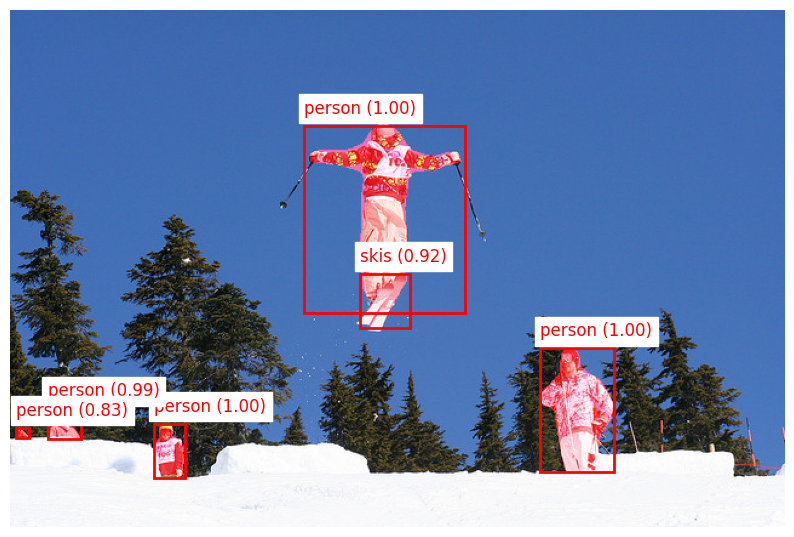

In [43]:
if __name__ == "__main__":
    # Path to a single image
    image_path = '/content/drive/MyDrive/Colab Notebooks/val2017/000000002473.jpg'

    # Annotation file for categories
    annotation_file = '/content/drive/MyDrive/Colab Notebooks/instances_val2017.json'

    # Load category mapping
    category_mapping = load_category_mapping(annotation_file)

    # Pretrained Mask R-CNN model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = maskrcnn_resnet50_fpn(pretrained=True)
    model.to(device)

    # Make predictions for the single image
    image, boxes, labels, scores, masks = predict_image(image_path, model, device, threshold=0.5)

    # Overlay masks on the image with transparency
    masked_image = overlay_masks(image, masks, transparency=0.9)

    # Visualize predictions with masked objects
    visualize_predictions(masked_image, boxes, labels, scores, category_mapping)